In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
SS_VER = 'SS_VER_1_1'

In [2]:
%run "../jupyter/Setup_Scripts/Setup_Generic.ipynb"

(ChipWhisperer Other WARNING|File __init__.py:69) ChipWhisperer update available! See https://chipwhisperer.readthedocs.io/en/latest/installing.html for updating instructions


INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$SS_VER"
cd ../tracescapture_20231127/20230818_dilithuim_new_new
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2

/bin/bash: line 1: cd: ../tracescapture_20231127/20230818_dilithuim_new_new: No such file or directory
make: *** No targets specified and no makefile found.  Stop.


CalledProcessError: Command 'b'cd ../tracescapture_20231127/20230818_dilithuim_new_new\nmake PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2\n'' returned non-zero exit status 2.

In [4]:
cw.program_target(scope, prog, "../tracescapture/20230818_dilithuim_new_new1/simple-test-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 24627 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 24627 bytes


In [5]:
import ctypes
import numpy as np
from picosdk.ps5000a import ps5000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok, mV2adc

# Create chandle and status ready for use
chandle = ctypes.c_int16()
status = {}

# Open 5000 series PicoScope
# Resolution set to 12 Bit
# 设置示波器的BIT，默认为12BIT
resolution =ps.PS5000A_DEVICE_RESOLUTION["PS5000A_DR_12BIT"]
# Returns handle to chandle for use in future API functions
status["openunit"] = ps.ps5000aOpenUnit(ctypes.byref(chandle), None, resolution)

try:
    assert_pico_ok(status["openunit"])
except: # PicoNotOkError:
    powerStatus = status["openunit"]
    if powerStatus == 286:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    elif powerStatus == 282:
        status["changePowerSource"] = ps.ps5000aChangePowerSource(chandle, powerStatus)
    else:
        raise
    assert_pico_ok(status["changePowerSource"])

In [6]:
# Set up channel A
# handle = chandle

# 注意这里要改成直流电！
channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
# enabled = 1
coupling_type = ps.PS5000A_COUPLING["PS5000A_DC"]
# 更改A通道（采集触发信号的通道）的范围
chARange = ps.PS5000A_RANGE["PS5000A_20V"]
# analogue offset = 0 V
status["setChA"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type, chARange, 0)
assert_pico_ok(status["setChA"])

# Set up channel B
# handle = chandle
channel = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
# enabled = 1

# 注意这里要改成交流电！!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
coupling_type2 = ps.PS5000A_COUPLING["PS5000A_AC"]
#chBRange = ps.PS5000A_RANGE["PS5000A_2V"]
# 更改B通道（采出来数据的通道）的范围
chBRange = ps.PS5000A_RANGE["PS5000A_50MV"]
# analogue offset = 0 V
status["setChB"] = ps.ps5000aSetChannel(chandle, channel, 1, coupling_type2, chBRange, 0)
assert_pico_ok(status["setChB"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps5000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

# Set up single trigger
# handle = chandle
# enabled = 1
source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
threshold = int(mV2adc(2500,chARange, maxADC))
# direction = PS5000A_RISING = 2
# delay = 0 s
# auto Trigger = 1000 ms
#status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 1000)
status["trigger"] = ps.ps5000aSetSimpleTrigger(chandle, 1, source, threshold, 2, 0, 20000)

assert_pico_ok(status["trigger"])
print(threshold)


# Set number of pre and post trigger samples to be collected
#####################参数###############################################
# 在触发之前采集的数量
preTriggerSamples = 0
# 在触发之后采集的数量

# postTriggerSamples = 46000
postTriggerSamples = 50000
#####################################################################
maxSamples = preTriggerSamples + postTriggerSamples

# Get timebase information
# Warning: When using this example it may not be possible to access all Timebases as all channels are enabled by default when opening the scope.  
# To access these Timebases, set any unused analogue channels to off.
# handle = chandle

#####################参数#############################
#timebase = 8
# 通过timebase来控制采样率
# 采样率的计算可以查手册，也可以用pico3000的那个控件来查看
timebase = 10
######################################################
#timebase = 8  , 20.8 MHZ
# noSamples = maxSamples
# pointer to timeIntervalNanoseconds = ctypes.byref(timeIntervalns)
# pointer to maxSamples = ctypes.byref(returnedMaxSamples)
# segment index = 0
timeIntervalns = ctypes.c_float()
returnedMaxSamples = ctypes.c_int32()
status["getTimebase2"] = ps.ps5000aGetTimebase2(chandle, timebase, maxSamples, ctypes.byref(timeIntervalns), ctypes.byref(returnedMaxSamples), 0)
assert_pico_ok(status["getTimebase2"])

4096


In [7]:
%matplotlib notebook
import matplotlib.pylab as plt

In [8]:
import random

In [9]:
def convert_msg(m,length):
    res = []
    for j in range(0,length): 
        s = m[j*2:j*2+2]
        s = "0x" + s
        res.append(int(s,16))
        #print(s,end=',')
    
    return res

In [10]:
convert_msg("225d5ce2ceac61930a07503fb59f7c2f936a3e075481da3ca299a80f8c5df9223a", 33)


[34,
 93,
 92,
 226,
 206,
 172,
 97,
 147,
 10,
 7,
 80,
 63,
 181,
 159,
 124,
 47,
 147,
 106,
 62,
 7,
 84,
 129,
 218,
 60,
 162,
 153,
 168,
 15,
 140,
 93,
 249,
 34,
 58]

In [11]:
下面是攻击集部分

NameError: name '下面是攻击集部分' is not defined

  0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\shagua\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


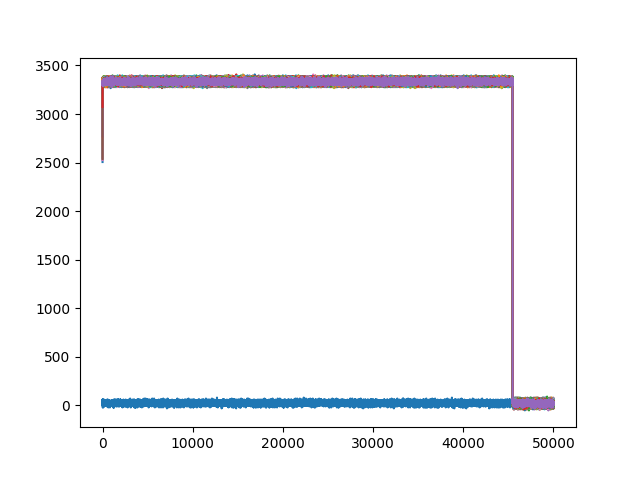

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
from tqdm import tnrange
from tqdm.auto import tqdm
import gc
################这里是参数部分，可以修改##############################
traces_per_part = 500  # 每一块文件多少条曲线
part = 20  # 分成多少块文件

part_start_index = 0  # 序号从多少块开始。如果是初始采集，就设置为0

#################################################################
filename_of_traces = r"F:\TracesCapture_demo\traces_for_attack"	# 曲线文件的文件名前缀
infile = open(r"F:\attack1.txt")
MLEN = 33
SEEDBYTES = 32
rhoprime_len = 48
global_counter = 0
total_traces = part * traces_per_part  # 总共要采集的曲线数目
pbar = tqdm(total=total_traces)
L = 4


def mainProcess(num_of_traces, myfile):

    traces_array = np.empty(shape=(traces_per_part,maxSamples),dtype=np.float64)
    text_in_array = np.empty(shape=(traces_per_part,33),dtype=np.uint8)
    text_out_array = np.empty(shape=(traces_per_part,1),dtype=np.uint8)
    

    for index_i in tnrange(num_of_traces):
        reset_target(scope)
        global global_counter
        global pbar
        msg_input = []

        line = infile.readline()
        while(line.find('counter=') == -1):
            line = infile.readline()
            
        counter  = line
        
        line = infile.readline()
        line = infile.readline()
        
        index_rhoprime = line.find('rhoprime=') + 9
        

        msg_input += convert_msg(line[index_rhoprime:index_rhoprime+rhoprime_len*2], rhoprime_len)
        
        line = infile.readline()

        
        nonce_index = line.find('nonce=') + 6
        nonce = int(line[nonce_index:nonce_index+4],16)
        #print(nonce)
        nonce = (nonce - 1) * L
        line = infile.readline()
        mark_index_st = line.find('mark_index=') + 11
        mark_index = int(line[mark_index_st:mark_index_st+1])

        
        nonce += int(mark_index)
        
        #nonce 是uint16 需小端序输入
        nonce_bytes = nonce.to_bytes(2, 'little')
       
        msg_input += [int(nonce_bytes[0])]
        msg_input += [int(nonce_bytes[1])]


        
        line = infile.readline()
        r_f4bytes_st = line.find('r_f4bytes') + 13
        r_f4bytes = line[r_f4bytes_st:-1]
        r_f4bytes = list(convert_msg(r_f4bytes,16))

        line = infile.readline()
        r_l4bytes_st = line.find('r_l4bytes') + 13
        r_l4bytes = line[r_l4bytes_st:-1]
        r_l4bytes = list(convert_msg(r_l4bytes,16))

        
        global_counter += 1

        target.simpleserial_write('z', bytearray(msg_input))
        time.sleep(0.01)
        
        status["runBlock"] = ps.ps5000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, None, 0, None, None)
        assert_pico_ok(status["runBlock"])
        
        ready = ctypes.c_int16(0)
        check = ctypes.c_int16(0)
        while ready.value == check.value:
            status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))
            
        
        bufferAMax = (ctypes.c_int16 * maxSamples)()
        bufferAMin = (ctypes.c_int16 * maxSamples)() 
        bufferBMax = (ctypes.c_int16 * maxSamples)()
        bufferBMin = (ctypes.c_int16 * maxSamples)()
        source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
        status["setDataBuffersA"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxSamples, 0, 0)
        assert_pico_ok(status["setDataBuffersA"])
        source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
        status["setDataBuffersB"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxSamples, 0, 0)
        assert_pico_ok(status["setDataBuffersB"])
        overflow = ctypes.c_int16()
        cmaxSamples = ctypes.c_int32(maxSamples)
        
        
        status["getValues"] = ps.ps5000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
        assert_pico_ok(status["getValues"])
        adc2mVChAMax =  adc2mV(bufferAMax, chARange, maxADC)
        adc2mVChBMax =  adc2mV(bufferBMax, chBRange, maxADC)
        # ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
        # 正式采集之前，先采集一条曲线的触发信号，并画图观察触发的上升沿和下降沿是否全部捕捉到，若看不到下降沿，则尝试增大postTriggerSamples
        plt.plot(adc2mVChAMax[:])	# 画图观察触发信号是否正常
#         plt.plot(adc2mVChBMax[:])	# 画图观察数据信号
        if adc2mVChBMax[0] == 32512 and adc2mVChBMax[-1] == 32512:
            raise Exception('示波器采集错误，请重新采集')
        #time.sleep(0.01)
        recv_msg = list(target.simpleserial_read('r', 32))
#         print(recv_msg)
#         for i in range(16):
#             assert r_f4bytes[i] == recv_msg[i]
#             assert r_l4bytes[i] == recv_msg[i+16]
            

        traces_array[index_i] = np.array(adc2mVChBMax[:])


                
        
        
        global_counter += 1
        pbar.update(1)
    return traces_array, text_in_array, text_out_array


# 先找到和part_start_index对应的counter
while(global_counter != traces_per_part * part_start_index):
    line = infile.readline()   
    if(line.find('counter=')!= -1):
        global_counter += 1


#print("here",global_counter )
for p in range(part):  # 遍历所有的part
    traces_arr, text_in_arr, text_out_arr = mainProcess(traces_per_part, infile)
    np.save(filename_of_traces + "_part{0}.npy".format(p + part_start_index), traces_arr)
    #np.save(filename_of_traces + "_textinPart{0}.npy".format(p + part_start_index), text_in_arr)
    #np.save(filename_of_traces + "_textoutPart{0}.npy".format(p + part_start_index), text_out_arr)
    del traces_arr
    del text_in_arr
    del text_out_arr
    gc.collect()
pbar.close()
infile.close()

In [17]:
plt.plot(adc2mVChAMax[:])

NameError: name 'adc2mVChAMax' is not defined

In [44]:
下面是profiling

NameError: name '下面是profiling' is not defined

In [67]:
from tqdm import tnrange
from tqdm.auto import tqdm
import gc
################这里是参数部分，可以修改##############################
traces_per_part = 500  # 每一块文件多少条曲线
part = 90  # 分成多少块文件

part_start_index = 0  # 序号从多少块开始。如果是初始采集，就设置为0

#################################################################
filename_of_traces = r"F:\TracesCapture_demo\traces_for_profiling"	# 曲线文件的文件名前缀
infile = open(r"F:\Dilithium\train\test.txt")
MLEN = 33
SEEDBYTES = 32
rhoprime_len = 48
global_counter = 0
total_traces = part * traces_per_part  # 总共要采集的曲线数目
pbar = tqdm(total=total_traces)
L = 4


def mainProcess(num_of_traces, myfile):

    traces_array = np.empty(shape=(traces_per_part,maxSamples),dtype=np.float64)
    text_in_array = np.empty(shape=(traces_per_part,33),dtype=np.uint8)
    text_out_array = np.empty(shape=(traces_per_part,1),dtype=np.uint8)
    

    for index_i in tnrange(num_of_traces):
        reset_target(scope)
        global global_counter
        global pbar
        msg_input = []

        line = infile.readline()
        while(line.find('counter=') == -1):
            line = infile.readline()
            
        counter  = line
        
        line = infile.readline()
        line = infile.readline()
        
        index_rhoprime = line.find('rhoprime=') + 9
        

        msg_input += convert_msg(line[index_rhoprime:index_rhoprime+rhoprime_len*2], rhoprime_len)
        
        line = infile.readline()

        
        nonce_index = line.find('nonce=') + 6
        nonce = int(line[nonce_index:nonce_index+4],16)
        #print(nonce)
        nonce = (nonce - 1) * L
        line = infile.readline()
        mark_index_st = line.find('mark_index=') + 11
        mark_index = int(line[mark_index_st:mark_index_st+1])

        
        nonce += int(mark_index)
        
        #nonce 是uint16 需小端序输入
        nonce_bytes = nonce.to_bytes(2, 'little')
       
        msg_input += [int(nonce_bytes[0])]
        msg_input += [int(nonce_bytes[1])]


        
        line = infile.readline()
        r_f4bytes_st = line.find('r_f4bytes') + 13
        r_f4bytes = line[r_f4bytes_st:-1]
        r_f4bytes = list(convert_msg(r_f4bytes,16))

        line = infile.readline()
        r_l4bytes_st = line.find('r_l4bytes') + 13
        r_l4bytes = line[r_l4bytes_st:-1]
        r_l4bytes = list(convert_msg(r_l4bytes,16))

        
        global_counter += 1

        target.simpleserial_write('z', bytearray(msg_input))
        time.sleep(0.01)
        
        status["runBlock"] = ps.ps5000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, None, 0, None, None)
        assert_pico_ok(status["runBlock"])
        
        ready = ctypes.c_int16(0)
        check = ctypes.c_int16(0)
        while ready.value == check.value:
            status["isReady"] = ps.ps5000aIsReady(chandle, ctypes.byref(ready))
            
        
        bufferAMax = (ctypes.c_int16 * maxSamples)()
        bufferAMin = (ctypes.c_int16 * maxSamples)() 
        bufferBMax = (ctypes.c_int16 * maxSamples)()
        bufferBMin = (ctypes.c_int16 * maxSamples)()
        source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_A"]
        status["setDataBuffersA"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferAMax), ctypes.byref(bufferAMin), maxSamples, 0, 0)
        assert_pico_ok(status["setDataBuffersA"])
        source = ps.PS5000A_CHANNEL["PS5000A_CHANNEL_B"]
        status["setDataBuffersB"] = ps.ps5000aSetDataBuffers(chandle, source, ctypes.byref(bufferBMax), ctypes.byref(bufferBMin), maxSamples, 0, 0)
        assert_pico_ok(status["setDataBuffersB"])
        overflow = ctypes.c_int16()
        cmaxSamples = ctypes.c_int32(maxSamples)
        
        
        status["getValues"] = ps.ps5000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
        assert_pico_ok(status["getValues"])
        adc2mVChAMax =  adc2mV(bufferAMax, chARange, maxADC)
        adc2mVChBMax =  adc2mV(bufferBMax, chBRange, maxADC)
        # ❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗❗
        # 正式采集之前，先采集一条曲线的触发信号，并画图观察触发的上升沿和下降沿是否全部捕捉到，若看不到下降沿，则尝试增大postTriggerSamples
#         plt.plot(adc2mVChAMax[:])	# 画图观察触发信号是否正常
        #plt.plot(adc2mVChBMax[:])	# 画图观察数据信号
        if adc2mVChBMax[0] == 32512 and adc2mVChBMax[-1] == 32512:
            raise Exception('示波器采集错误，请重新采集')
        #time.sleep(0.01)
        recv_msg = list(target.simpleserial_read('r', 32))
#         print(recv_msg)
        for i in range(16):
            assert r_f4bytes[i] == recv_msg[i]
            assert r_l4bytes[i] == recv_msg[i+16]
            

        traces_array[index_i] = np.array(adc2mVChBMax[:])


                
        
        
        global_counter += 1
        pbar.update(1)
    return traces_array, text_in_array, text_out_array


# 先找到和part_start_index对应的counter
while(global_counter != traces_per_part * part_start_index):
    line = infile.readline()   
    if(line.find('counter=')!= -1):
        global_counter += 1


#print("here",global_counter )
for p in range(part):  # 遍历所有的part
    traces_arr, text_in_arr, text_out_arr = mainProcess(traces_per_part, infile)
    np.save(filename_of_traces + "_part{0}.npy".format(p + part_start_index), traces_arr)
    #np.save(filename_of_traces + "_textinPart{0}.npy".format(p + part_start_index), text_in_arr)
    #np.save(filename_of_traces + "_textoutPart{0}.npy".format(p + part_start_index), text_out_arr)
    del traces_arr
    del text_in_arr
    del text_out_arr
    gc.collect()
pbar.close()
infile.close()

  0%|          | 0/45000 [00:00<?, ?it/s]

C:\Users\shagua\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:29: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
int("0x0b",16)

11

In [75]:
gc.collect()

21

In [116]:
# Stop the scope
# handle = chandle
status["stop"] = ps.ps5000aStop(chandle)
assert_pico_ok(status["stop"])

# Close unit Disconnect the scope
# handle = chandle
status["close"]=ps.ps5000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# display status returns
print(status)

{'openunit': 286, 'changePowerSource': 0, 'setChA': 0, 'setChB': 0, 'maximumValue': 0, 'trigger': 0, 'getTimebase2': 0, 'runBlock': 0, 'isReady': 0, 'setDataBuffersA': 0, 'setDataBuffersB': 0, 'getValues': 0, 'stop': 0, 'close': 0}


In [ ]:
以下是用gdb 和 openocd 进行 DEBUG

In [ ]:
检查是否支持：

In [ ]:
import chipwhisperer as cw
if cw.__version__ < '5.6.1':
    print("MPSSE not supported.")
else:
    scope = cw.scope()
    if scope.check_feature("MPSSE"):
        print("MPSSE supported!")
    else:
        print("MPSSE not supported.")
    scope.dis()

In [ ]:
❗

In [ ]:
import chipwhisperer as cw
scope = cw.scope()
PID = hex(scope._getNAEUSB().usbtx.device.getProductID())
scope.enable_MPSSE(1)
scope.dis()

In [ ]:
下面是测试自己的固件，注意要make

In [ ]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'
SS_VER = 'SS_VER_1_1'

In [ ]:
%%bash -s "$PLATFORM" "$SS_VER"
cd ../tracesCapture/dilithium_firmware_cortex_m_6_4
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2

In [ ]:
下面是测试能否写入

In [ ]:
%%bash -s "$PID"

# build firmware
cd ../tracesCapture/dilithium_firmware_cortex_m_6_4

# upload firmware via JTAG
openocd -f ../../cw_openocd.cfg -c "transport select jtag" -c "ftdi vid_pid 0x2b3e $1" -f "target/stm32f3x.cfg" -c "init" -c "targets" -c "halt" -c "flash write_image erase simple-test-CW308_STM32F3.elf" -c "flash verify_image simple-test-CW308_STM32F3.elf" -c "reset run" -c "shutdown"

In [ ]:
❗需要直接运行下面这一块，运行这一块会阻塞，监听。如果gdb那边出问题，需要在这里kernel restart,重新来一遍
板子不需要拔出

In [ ]:
%%bash -s "$PID"

cd ../tracesCapture/dilithium_firmware_cortex_m_6_4

openocd -f ../../cw_openocd.cfg -c "transport select jtag" -c "ftdi vid_pid 0x2b3e $1" -f "target/stm32f3x.cfg"

In [ ]:
以下放在终端中运行

In [ ]:
cd tracesCapture/dilithium_firmware_cortex_m_6_4


arm-none-eabi-gdb simple-test-CW308_STM32F3.elf -ex "target extended-remote localhost:3333" -ex "monitor reset halt" -ex "load"

In [ ]:
以下是测试默认的AES固件

In [ ]:
下面这一块不用运行，但是是测试

In [ ]:
%%bash -s "$PID"

# build firmware
cd ../hardware/victims/firmware/simpleserial-aes
make PLATFORM=CW308_STM32F3 CRYPTO_TARGET=TINYAES128C SS_VER=SS_VER_1_1 -j

# upload firmware via JTAG
openocd -f ../../../../cw_openocd.cfg -c "transport select jtag" -c "ftdi vid_pid 0x2b3e $1" -f "target/stm32f3x.cfg" -c "init" -c "targets" -c "halt" -c "flash write_image erase simpleserial-aes-CW308_STM32F3.elf" -c "flash verify_image simpleserial-aes-CW308_STM32F3.elf" -c "reset run" -c "shutdown"

In [ ]:
需要直接运行下面这一块，运行这一块会阻塞，监听

In [ ]:
%%bash -s "$PID"

cd ../hardware/victims/firmware/simpleserial-aes

openocd -f ../../../../cw_openocd.cfg -c "transport select jtag" -c "ftdi vid_pid 0x2b3e $1" -f "target/stm32f3x.cfg"

In [ ]:
这个放在shell中运行，不要放在notebook里运行
cd hardware/victims/firmware/simpleserial-aes 
arm-none-eabi-gdb simpleserial-aes-CW308_STM32F3.elf -ex "target extended-remote localhost:3333" -ex "monitor reset halt" -ex "load" 

In [ ]:
gdb里，想要重启，先load，再s，再start。如果load后直接start，没用，不知道为啥

In [ ]:
a = "7c9935a0b07694aac6d10e4db6b1add2fd81a25ccb14832dcd739936737f2d00000000210000000a012bf0de55008014bf0de550060000000600000001000000061408affdd5500"

a = a[0:64]

print(a)

In [ ]:
seed=[] 
for i in range(0,32):
    seed.append(random.randint(0,255))
    
for x in seed:
    print(hex(x),end=',')

In [ ]:
msg=[] 
for i in range(0,33):
    msg.append(random.randint(0,255))
    
for x in msg:
    print(hex(x),end=',')

In [ ]:
a = np.load('F:/dilithuim采集/batch0_textinPart0.npy')
print(a)

In [ ]:
a = np.load('F:/dilithuim采集/batch0_textoutPart0.npy')
print(a)

In [ ]:
seed ="ef99224a03a85a46ef115474ec5b5d620da6795d6efcca4c9135d19958a9de62"
#seed = "ef99224a03a85a46ef115474ec5b5d620da6795d6efcca4c9135d19958a9de62"
for i in range(0,32): 
    s = seed[i*2:i*2+2]
    s = "0x" + s
    print(s,end=',')

In [12]:
# 拿到原始数据后，运行一下这个，生成元数据文件!!!!!!!!!!
# 注意要改名字！！！！！！！！！！！！！！！

file1 = open('F:/dilithuim采集/元数据/find_for_profiling.txt', 'r')
Lines = file1.readlines()

f = open("F:/dilithuim采集/元数据/meta_data_for_profiling.txt", "w")
f.write("THIS IS METADATA\n")

count = 0


for line in Lines:
    #print("Line{}: {}".format(count, line.strip()))
    content = line.strip()
    if(content.find("successfully") == -1):
        continue
    
    seed_start = content.find("seed=") + 5
    seed_end = content.find("--successfully")
    seed = content[seed_start:seed_end].strip()
    
    pk_start = content.find("pk=") +3
    pk_end= content.find("---sk=")
    pk = content[pk_start:pk_end].strip()
    
    sk_start = content.find("sk=")+3
    sk_end= content.find("---smlen=")
    sk = content[sk_start:sk_end].strip()
    
    msg_start = content.find("msg=") + 4
    msg_end = content.find(",seed=")
    msg = content[msg_start:msg_end].strip()
    
    msg_len_start = content.find("---mlen=")+8
    msg_len_end = content.find("---sm=")
    msg_len = content[msg_len_start:msg_len_end].strip()
    
    sm_start = content.find("sm=")+3
    sm = content[sm_start:].strip()
    
    sm_len_start = content.find("smlen=")+6
    sm_len_end = content.find("---mlen")
    sm_len = content[sm_len_start:sm_len_end].strip()

    

    f.write("count= " + str(count) +"\n")
    f.write("seed= " + seed+"\n")
    f.write("pk= " + pk+"\n")
    f.write("sk= " + sk+"\n")
    f.write("msg= " + msg+"\n")
    f.write("msg_len= " + msg_len+"\n")
    f.write("sm= " + sm+"\n")
    f.write("sm_len= " + sm_len+"\n")
    f.write("\n")
    count += 1
    
f.close()

In [ ]:
分割文件

In [20]:
file1 = open('F:/dilithium采集-比赛用/训练集/meta_data_for_profiling_new.txt', 'r')



traces_per_part = 50  # 每一块文件多少条曲线
part = 200  # 分成多少块文件
part_start_index = 0  # 序号从多少号开始。如果是初始采集，就设置为0



for p in range(part):  # 遍历所有的part
    f = open("F:/dilithium采集-比赛用/训练集/meta_data_for_profiling_part{0}".format(p) + ".txt", "w")

    for tp in range(traces_per_part):
        content = file1.readline()
        count_start = content.find("count=") + 7
        count = content[count_start:].strip()
        
        
        content = file1.readline()
        seed_start = content.find("seed=") + 6
        seed = content[seed_start:].strip()
        
        content = file1.readline()
        pk_start = content.find("pk=") +4
        pk = content[pk_start:].strip()
        
        
        content = file1.readline()
        sk_start = content.find("sk=")+4
        sk = content[sk_start:].strip()
        
        
        content = file1.readline()
        msg_start = content.find("msg=") + 5
        msg = content[msg_start:].strip()
        
        
        content = file1.readline()
        msg_len_start = content.find("msg_len=")+9
        msg_len = content[msg_len_start:].strip()
        
        content = file1.readline()
        sm_start = content.find("sm=")+4
        sm = content[sm_start:].strip()
        
        content = file1.readline()
        sm_len_start = content.find("sm_len=")+8
        sm_len = content[sm_len_start:].strip()



        f.write("count= " + str(count) +"\n")
        f.write("seed= " + seed+"\n")
        f.write("pk= " + pk+"\n")
        f.write("sk= " + sk+"\n")
        f.write("msg= " + msg+"\n")
        f.write("msg_len= " + msg_len+"\n")
        f.write("sm= " + sm+"\n")
        f.write("sm_len= " + sm_len+"\n")
        f.write("\n")
        content = file1.readline()

    f.close()

In [4]:
# 拿到原始数据后，运行一下这个，生成元数据文件!!!!!!!!!!
# 注意要改名字！！！！！！！！！！！！！！！

file1 = open('F:/dilithuim采集/元数据/20230828.txt', 'r')
Lines = file1.readlines()

f = open("F:/dilithuim采集/元数据/20230828_new.txt", "w")

count = 0


for line in Lines:
    #print("Line{}: {}".format(count, line.strip()))
    content = line.strip()
    if(content.find("successfully") == -1):
        continue
    
    seed_start = content.find("seed=") + 5
    seed_end = content.find("--rhoprime")
    seed = content[seed_start:seed_end].strip()
    
    rhoprime_start = content.find("rhoprime=") + 9
    rhoprime_end = content.find("--nonce=")
    rhoprime = content[rhoprime_start:rhoprime_end].strip()
    
    nonce_start = content.find("nonce=") + 6
    nonce_end = content.find("--y=")
    nonce = content[nonce_start:nonce_end].strip()
    
    r_f4bytes0_st = content.find("r_f4bytes[0]=") + 13
    r_f4bytes0_end = content.find("--r_l4bytes[0]") 
    f4bytes0 = content[r_f4bytes0_st:r_f4bytes0_end].strip()
    
    r_l4bytes0_st = content.find("r_l4bytes[0]=") + 13
    r_l4bytes0_end = content.find("--r_f4bytes[1]") 
    l4bytes0 = content[r_l4bytes0_st:r_l4bytes0_end].strip()
    
    r_f4bytes1_st = content.find("r_f4bytes[1]=") + 13
    r_f4bytes1_end = content.find("--r_l4bytes[1]")
    f4bytes1 = content[r_f4bytes1_st:r_f4bytes1_end].strip()

    r_l4bytes1_st = content.find("r_l4bytes[1]=") + 13
    r_l4bytes1_end = content.find("--r_f4bytes[2]")
    l4bytes1 = content[r_l4bytes1_st:r_l4bytes1_end].strip()

        
    r_f4bytes2_st = content.find("r_f4bytes[2]=") + 13
    r_f4bytes2_end = content.find("--r_l4bytes[2]")
    f4bytes2 = content[r_f4bytes2_st:r_f4bytes2_end].strip()

    
    r_l4bytes2_st = content.find("r_l4bytes[2]=") + 13
    r_l4bytes2_end = content.find("--r_f4bytes[3]")
    l4bytes2 = content[r_l4bytes2_st:r_l4bytes2_end].strip()

    
    r_f4bytes3_st = content.find("r_f4bytes[3]=") + 13
    r_f4bytes3_end = content.find("--r_l4bytes[3]")
    f4bytes3 = content[r_f4bytes3_st:r_f4bytes3_end].strip()

        
    r_l4bytes3_st = content.find("r_l4bytes[3]") + 13
    r_l4bytes3_end = content.find("--successfull")
    l4bytes3 = content[r_l4bytes3_st:r_l4bytes3_end].strip()

        
    pk_start = content.find("pk=") +3
    pk_end= content.find("---sk=")
    pk = content[pk_start:pk_end].strip()
    
    sk_start = content.find("sk=")+3
    sk_end= content.find("---smlen=")
    sk = content[sk_start:sk_end].strip()
    
    msg_start = content.find("msg=") + 4
    msg_end = content.find(",seed=")
    msg = content[msg_start:msg_end].strip()
    
    msg_len_start = content.find("---mlen=")+8
    msg_len_end = content.find("---sm=")
    msg_len = content[msg_len_start:msg_len_end].strip()
    
    sm_start = content.find("sm=")+3
    sm = content[sm_start:].strip()
    
    sm_len_start = content.find("smlen=")+6
    sm_len_end = content.find("---mlen")
    sm_len = content[sm_len_start:sm_len_end].strip()

    

    f.write("count= " + str(count) +"\n")
    f.write("seed= " + seed+"\n")
    f.write("rhoprime= " + rhoprime+"\n")
    f.write("nonce= " + nonce+"\n")
    f.write("[0] first 4bytes=" + f4bytes0 + "\n")
    f.write("[0] last 4bytes=" + l4bytes0 + "\n")
    f.write("[1] first 4bytes=" + f4bytes1 + "\n")
    f.write("[1] last 4bytes=" + l4bytes1 + "\n")
    f.write("[2] first 4bytes=" + f4bytes2 + "\n")
    f.write("[2] last 4bytes=" + l4bytes2 + "\n")
    f.write("[3] first 4bytes=" + f4bytes3 + "\n")
    f.write("[3] last 4bytes=" + l4bytes3 + "\n")
    f.write("pk= " + pk+"\n")
    f.write("sk= " + sk+"\n")
    f.write("msg= " + msg+"\n")
    f.write("msg_len= " + msg_len+"\n")
    f.write("sm= " + sm+"\n")
    f.write("sm_len= " + sm_len+"\n")
    f.write("\n")
    count += 1
    
f.close()

In [109]:
"nnihao{0}.nihao{0}".format(1)

'nnihao1.nihao1'

In [ ]:
a = np.load("F:/dilithium采集-比赛用/攻击集/第0组/traces_batch0_part0.npy")
plt.plot(a.T)
plt.show()